In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
TRAIN = True
TRAIN_MODEL_3 = False

TRAIN_TEST_SPLIT_SEED = 42
TEST_SIZE = 0.1
TRAIN_FROM_CP = True  # CP===check point
EPOCHS = 1

TEST_FLOW = False

In [3]:
import sys

IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [4]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [5]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [6]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.2.7
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [7]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-02-16 09:10:17.425120: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_3928697/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


In [8]:
import mlflow

mlflow.tensorflow.autolog()

In [9]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [10]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [11]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [12]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [13]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [14]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [15]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [16]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [17]:
# yy.to_csv('contracts_to_review.csv')

In [18]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subj_len,headers,subject_pos,url,unseen,score,hash,dups,subject_weight,sample_weight
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,79.0,4.0,1444.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.489089e-01,1.466727e+18,1.0,0.836625,18.691956
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-15 19:40:44.884996,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,106.0,10.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.552332e-01,7.820601e+18,1.0,1.590543,55.701855
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-15 19:40:41.177191,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,30.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,6.378618e+18,1.0,1.379235,72.204732
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,53.0,12.0,100.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584e+00,-8.785895e+18,1.0,0.789799,28.766883
62dfbce15d5a202ba67b842d,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-15 19:41:01.685099,5550.0,2022-07-26 13:08:03.309000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/62df...,False,1.746836e+00,-5.929322e+18,4.0,5.367079,66.795704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380858b6a07f3e980b2c4c3,db,f9f2ddea91cdfe00b15e149fcf682ed8,3.0.0,2023-01-31 18:36:12.057993,10650.0,2022-11-25 19:27:25.157000+00:00,NaN,NaN,NaN,рублей,...,42.0,14.0,89.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,True,8.287081e+07,2.955294e+18,2.0,0.829831,1.123079
6152d6308558145da68d8753,db,9cd4b1020719eec68bf7b6efb7acdb82,2.4.6,2023-01-31 18:36:07.153221,4580.0,2021-09-28 11:46:57.520000+00:00,NaN,NaN,NaN,NaN,...,27.0,19.0,92.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6152...,True,8.287081e+07,1.152343e+18,1.0,0.299871,0.740613
63c506e3e2456d59975e151e,db,492fc5ef7c7d15f063fc924dca4fa0b5,23.01.04,2023-01-31 21:42:47.398166,8180.0,2023-01-16 14:28:06.456000+00:00,NaN,NaN,NaN,NaN,...,189.0,21.0,704.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,8.287081e+07,7.304332e+18,1.0,0.530020,1.392795


In [19]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]
len(user_dataset)


1208

In [20]:
mlflow.log_param('dataset_len_user', len(user_dataset) )
mlflow.log_param('dataset_len', len(stats) )

2782

In [21]:
print(len(stats))

2782


In [22]:
user_dataset[user_dataset.subj_len>=150]

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subj_len,headers,subject_pos,url,unseen,score,hash,dups,subject_weight,sample_weight
_id,,,,,,,,,,,,,,,,,,,,,
6391b4771864c6df4d29f332,db,22f701119d81787cd423f79f0f9fd9db,22.12.7,2023-02-10 19:46:00.164622,1990.0,2022-12-08 22:25:50.608000+00:00,1.000000e+11,25.328436,483.0,RUB,...,151.0,8.0,299.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6391...,False,2.350291,7.866256e+18,1.0,2.829004,44.804411
63908ca4a1bded13e629f2e4,db,665a638dc4f2c42ce670679ca76cff77,22.12.6,2023-02-07 17:45:41.189147,2020.0,2022-12-07 15:55:04.590000+00:00,1.500000e+10,23.431316,201.0,RUB,...,183.0,11.0,135.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,11.897562,-2.598282e+18,5.0,0.944654,41.598791
62838b2e4d1bfe5e5b297ddb,db,c81664bbc202b2a143fe57dfcb950348,3.0.0,2023-01-31 18:32:43.216593,25010.0,2022-05-17 14:47:43.209000+00:00,3.050000e+09,21.838407,14195.0,RUB,...,161.0,22.0,123.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6283...,False,21.185632,-6.402531e+18,5.0,1.401332,38.398341
5fb399dd39d5e82e90818477,db,44d1c22fb92ce75663dc046c184df359,2.0.5,2023-02-10 19:45:56.692593,5210.0,2020-11-17 09:58:23.635000+00:00,4.338600e+05,12.980479,2498.0,RUB,...,152.0,17.0,128.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,False,25.870122,2.551160e+18,1.0,0.797329,35.389183
62d149464ae369b4976e31f3,db,31b2973970123953ebc9074a4dfaa421,3.0.0,2023-02-10 19:45:58.627205,2050.0,2022-07-15 14:09:08.607000+00:00,1.000000e+04,9.210440,1010.0,RUB,...,170.0,11.0,94.0,http://gpn-audit.nemosoft.ru/#/audit/edit/62d1...,False,36.459341,-2.477580e+17,1.0,0.443299,26.170127
6380859e6a07f3e980b2c5c4,db,5d8d2a674adffa2c30fa1254e1047e40,3.0.0,2023-01-31 18:32:52.073085,4180.0,2022-11-25 20:00:26.236000+00:00,1.705600e+06,14.349428,1957.0,RUB,...,189.0,12.0,109.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,45.749616,-3.152327e+16,1.0,0.402716,15.870913
638085646a07f3e980b2c0e5,db,43519987735b5d2180168facc4404545,3.0.0,2023-01-31 18:32:45.290596,28200.0,2022-11-25 12:30:29.763000+00:00,3.147910e+05,12.659667,3424.0,RUB,...,190.0,45.0,2855.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,51.856088,-8.084576e+18,2.0,0.918505,34.311488
6380855c6a07f3e980b2c061,db,9756e819859af5192b5e44806f173d8c,22.12.7,2023-02-15 19:41:01.860408,1950.0,2022-12-08 16:02:19.987000+00:00,5.000000e+02,6.216606,363.0,RUB,...,188.0,10.0,141.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,57.076924,-2.892521e+18,1.0,0.741907,7.433833
6380857e6a07f3e980b2c343,db,24195a650ec51184b0b507d73fd67b7a,3.0.0,2023-01-31 18:32:46.337373,5020.0,2022-11-25 12:31:32.455000+00:00,2.923300e+07,17.190809,754.0,RUB,...,159.0,18.0,147.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,70.155888,2.636426e+18,1.0,0.451101,45.961202


# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [23]:
errors_file = Path(analyser.__file__).parent.parent /'trainsets' / 'errors.csv'
errors_file
errors_df = pd.read_csv(errors_file, index_col=0)
errors_df

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,сумма,сумма (старая),currency,Номер,сумма без налога,налог,vat_unit,сумма с налогом,subject
63ce4a56e83d1ee490f3f790,2023-02-12 09:08:11.045,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,раздел о предмете договора не указан; определе...,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,7.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3798558145da68d8788,2023-02-15 16:30:42.431,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Псевдоним 2 очень странный;\n,Наименование 2 отсутсвует;\nФорма собственност...,5.0,42.0,Service,NaN,NaN,Клиент,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615ac8cf8f3b0514f3f423f8,2021-10-04 09:30:37.752,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Номер не является номером;\n,Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...,5.0,37.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,№,NaN,NaN,NaN,NaN,NaN
612de89f4f22ff1b7e02fcd7,2021-10-21 12:37:11.447,https://gpn-audit.nemosoft.ru/#/audit/edit/612...,Валюта очень странная;\nналог не указан;\nНаим...,Псевдоним 2 отсутсвует;\n,5.0,110.0,Deal,Общество с ограниченной\nответственностью,Тазпромнефть-\nКаталитические системы,ПОКУПАТЕЛЬ,...,«27» апреля 2021,"2.1 Общая сумма Контракта составляет 12781300,...",NaN,EUR,№ ДП_76305_82273_33225,"12781300,00",NaN,NaN,NaN,NaN
6152e3af8558145da68d8790,2023-02-15 16:29:51.796,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\n,Наименование 2 отсутсвует;\nФорма собственност...,5.0,56.0,Service,NaN,NaN,Заказчик,...,NaN,"Общая стоимость услуг по Договору составляет, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5feb3e51bd24992aa3104108,2020-12-29 15:00:07.153,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,NaN,NaN,0.0,106.0,Insurance,Общество с ограниченной ответственностью,Газпромнефть-Снабжение,Страхователь,...,NaN,Страховая премия по настоящему Договору рассчи...,"300000,00",рублей,№ 159-875-658-ст,NaN,NaN,NaN,NaN,NaN
5fc63d611d0a1603c7a0c97b,2020-12-18 08:13:09.201,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,NaN,NaN,0.0,66.0,Charity,ООО,Газпромнефть НТЦ,Благотворитель,...,6 июня 2019,NaN,NaN,NaN,№ НТЦ-19/03000/00931,NaN,NaN,NaN,NaN,NaN
5fc6452a1d0a1603c7a0c9f0,2020-12-16 08:51:56.747,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,NaN,NaN,0.0,71.0,Charity,ООО,Газпромнефть НТЦ,Благотворитель,...,27 января 2020,NaN,NaN,NaN,№ НТЦ-20/03000/00080,NaN,NaN,NaN,NaN,NaN
6393256f1002115a6029f3f0,2023-02-04 08:05:50.469,https://gpn-audit.nemosoft.ru/#/audit/edit/639...,NaN,NaN,0.0,18.0,Loans,Общество с ограниченной ответственностью,Газпромнефть-Снабжение,Заемщик,...,«03» декабря 2017,3433397000 (Три миллиарда четыреста тридцать т...,3433397000,рублей,19/12100/03616,NaN,NaN,NaN,NaN,NaN


In [24]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2782


CONTRACT                   0.639675
SUPPLEMENTARY_AGREEMENT    1.091524
AGREEMENT                  1.268802
Name: documentType, dtype: float64

In [25]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [26]:
%time

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  #error weight
  error_weight = 1.0 
  if i in errors_df.index:
      error_weight = 1.0 + errors_df.at[i, 'errors count']


  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly    

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
    
  sample_weight /= error_weight  

  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
# stats.sample_weight /= stats.sample_weight.mean()
# stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

# stats

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.62 µs
15.979879418952889
0.8189935045186753
0.500032827794572
0.1250409720622056
150.67696203124433
5.663085704236934


In [27]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [28]:
%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

if not TEST_FLOW:
    for i in stats.index:

      try:
        validate_datapoint(str(i), stats)

      except Exception as e:
        logger.error(e)

        stats.at[i, 'valid'] = False
        stats.at[i, 'error'] = str(e)
    
# stats

 

umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.38 µs


ERROR - 2023-02-16 09:10:29,110 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fc6452a1d0a1603c7a0c9eb-datapoint-embeddings.npy'
ERROR - 2023-02-16 09:10:31,730 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb3d4a078df3635f5441c63-datapoint-embeddings.npy'
ERROR - 2023-02-16 09:10:33,763 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbad2ca2b4551c06107864-datapoint-embeddings.npy'


2779


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [29]:

len(stats_valid)

2779

In [30]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()





15.990110214575573
0.8192735860714266


In [31]:
print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MAX\t', stats.sample_weight.max())
print('MEAN\t', stats.sample_weight.mean())

1.0
0.1526241956143136


sample_weight
MIN	 0.03127138094012471
MAX	 9.42313467570078
MEAN	 0.9999999999999997


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


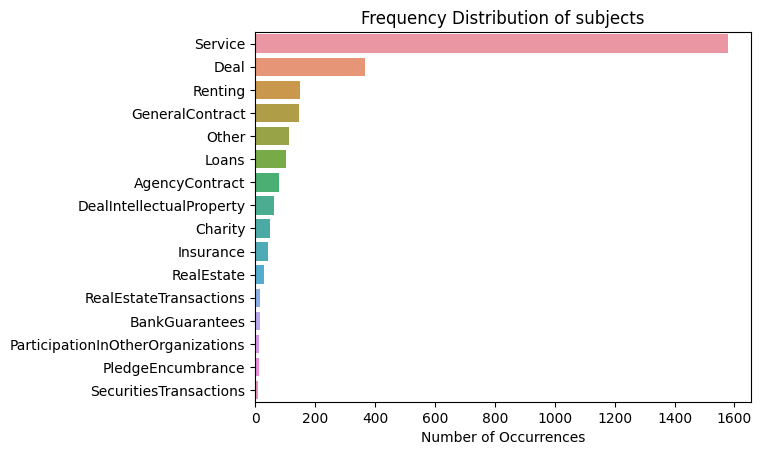


min 8
max 1577
total 2779


In [32]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [33]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Service', 'AgencyContract', 'Charity', 'Loans', 'SecuritiesTransactions', 'BankGuarantees', 'Renting', 'PledgeEncumbrance', 'Deal', 'DealIntellectualProperty', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.499604
Deal                                 0.622713
Renting                              0.735227
GeneralContract                      0.738228
Other                                0.778239
Loans                                0.793798
AgencyContract                       0.839575
DealIntellectualProperty             0.884622
Charity                              0.945326
Insurance                            0.966474
RealEstate                           1.081689
RealEstateTransactions               1.272860
BankGuarantees                       1.298539
ParticipationInOtherOrganizations    1.434351
PledgeEncumbrance                    1.434351
SecuritiesTransactions               1.674403
Name: subject, dtype: float64

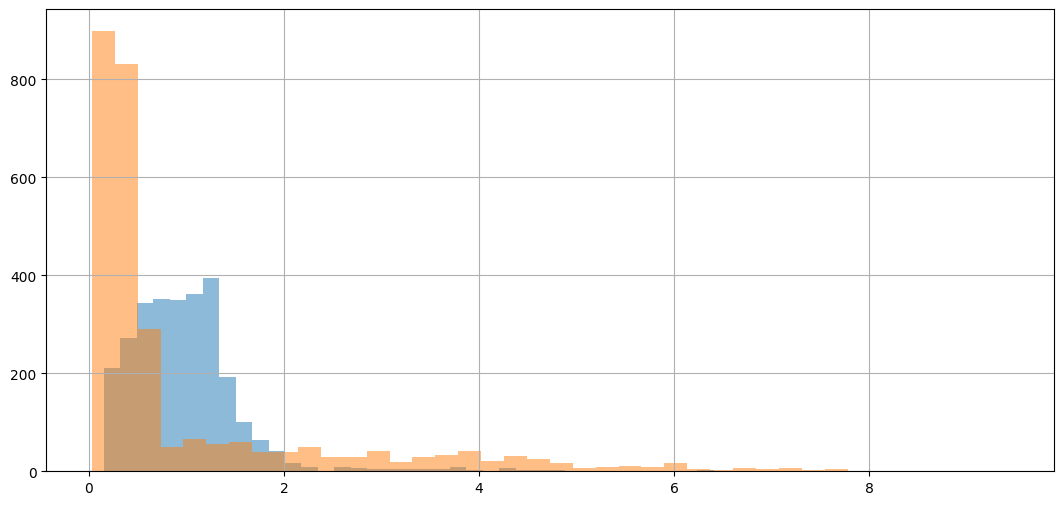

In [34]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

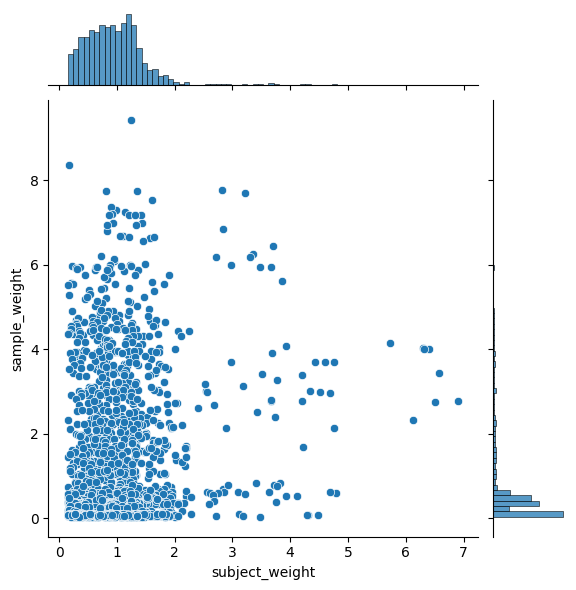

In [35]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5ded4e284ddc27bcf92dd6ce
semantic map shape is: (460, 30)


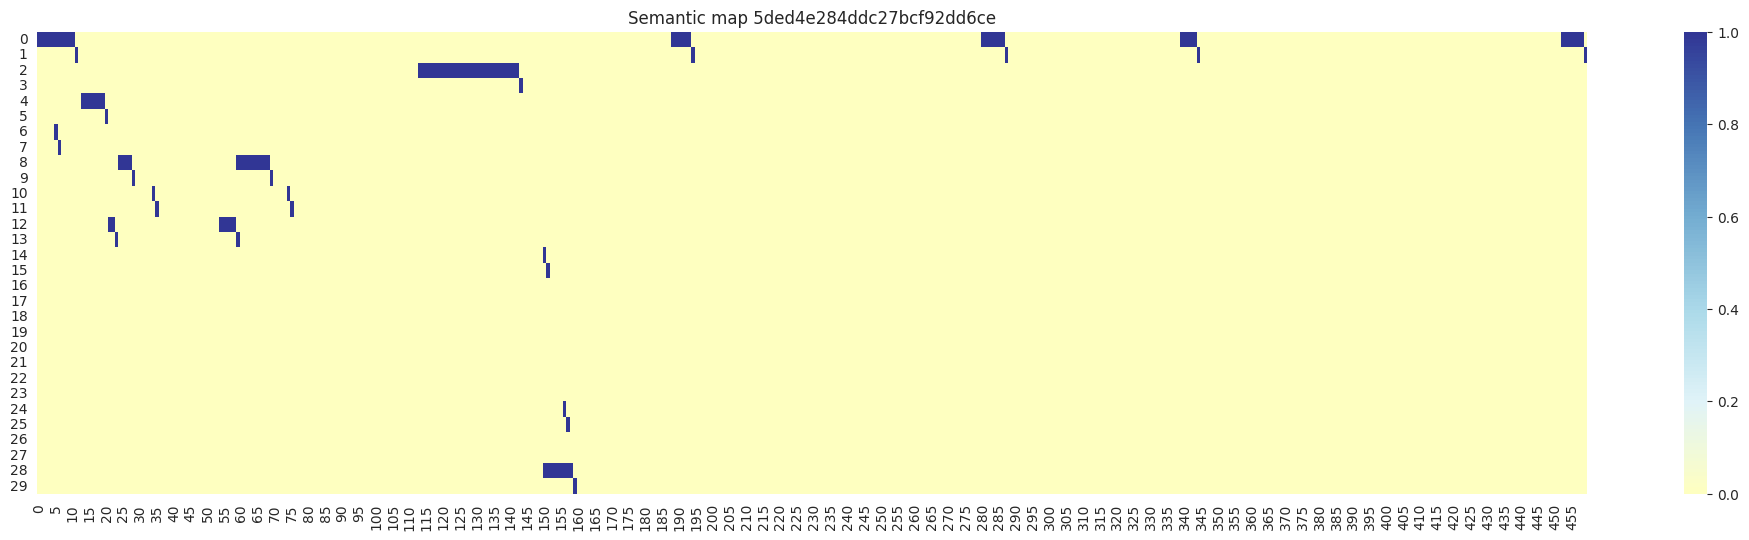

In [36]:
%matplotlib inline
# umtm.calculate_samples_weights()
 
SAMPLE_DOC_ID =  stats_valid.index[2]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
# plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
# plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



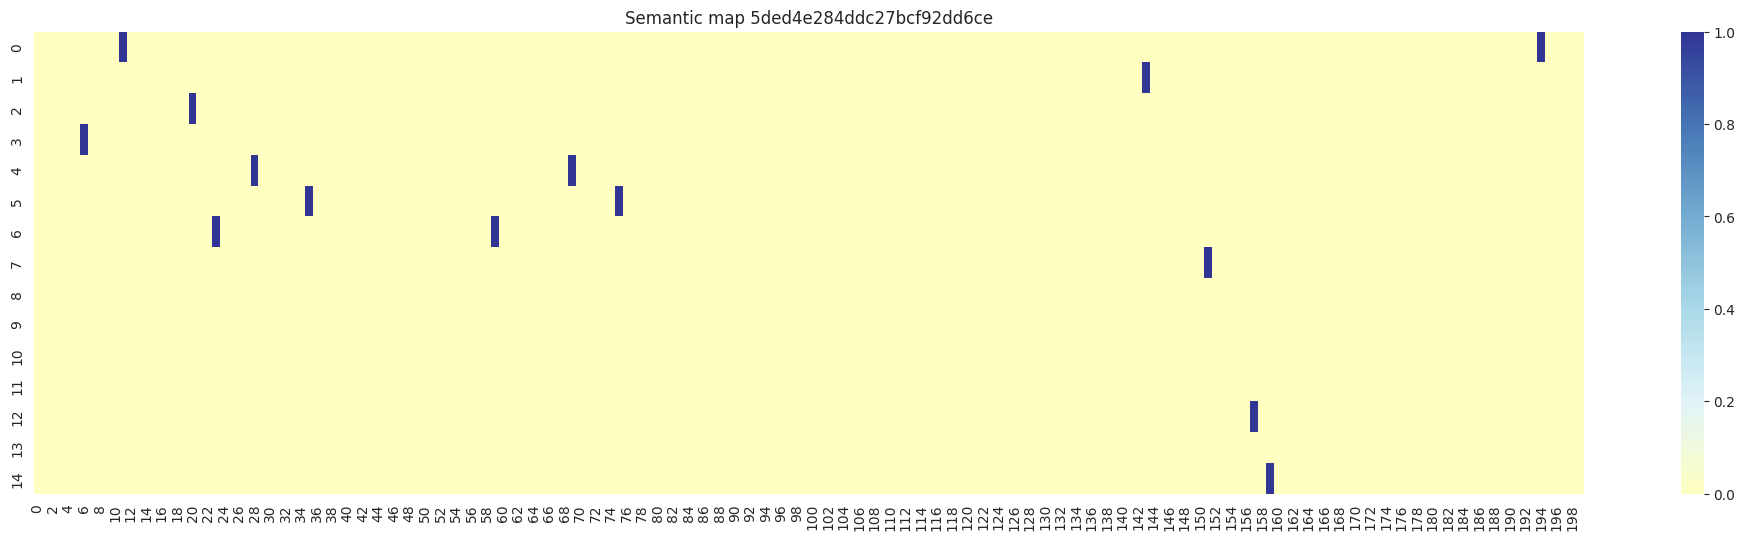

In [37]:


plot_embedding(sm[:, 1::2][:200], title=f'Semantic map {SAMPLE_DOC_ID}')

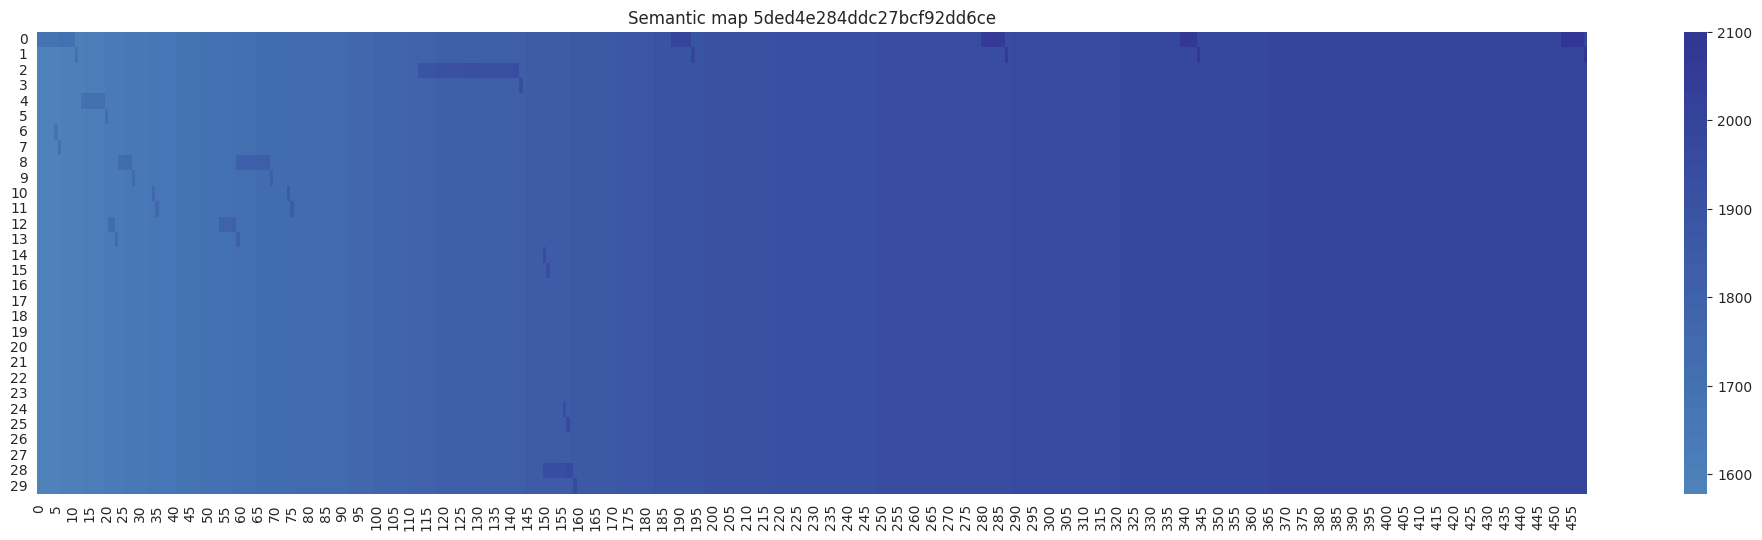

In [38]:
nonzerozz = np.where(sm[:, 1::2] > 0)[0]
max_len = 1536
# nonzerozz = list(set(nonzerozz))
# nonzerozz

# c=random.choice(nonzerozz)
# sm[c-1:c]
sm = sm*100.
for i in range(0,2000):
    segment_center = random.choice(nonzerozz)

    _off = random.randint(-max_len//40, max_len//2)
    start_from = segment_center - _off
    if start_from < 0:
        start_from = 0
    if start_from >=len(emb):
        start_from = len(emb)-1
    
    sm[start_from: start_from+max_len]+=1

plot_embedding(sm, title=f'Semantic map {SAMPLE_DOC_ID}')


In [39]:
nonzerozz

array([  6,  11,  20,  23,  28,  35,  59,  69,  75, 143, 151, 157, 159,
       194, 287, 344, 459])

In [40]:
del sm

In [41]:
# # sm[1].argmax()
# for i in range(0,10):
#     print(random.random() < 0.8)
# #     random_row = random.randint(0, sm.shape[-1])
# #     focus_pos = sm[random_row].argmax()
# #     print(random_row, focus_pos, sm[random_row][focus_pos])

# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

semantic map shape is: (10, 1256, 30)


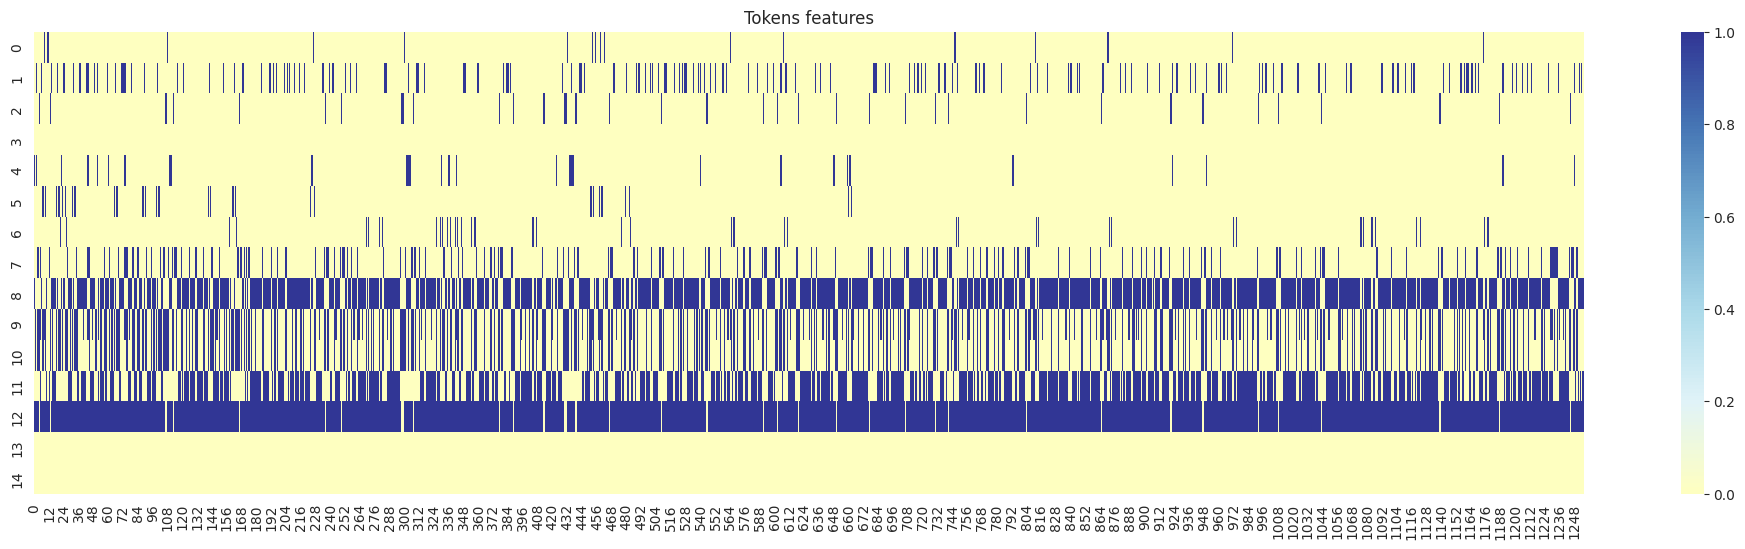

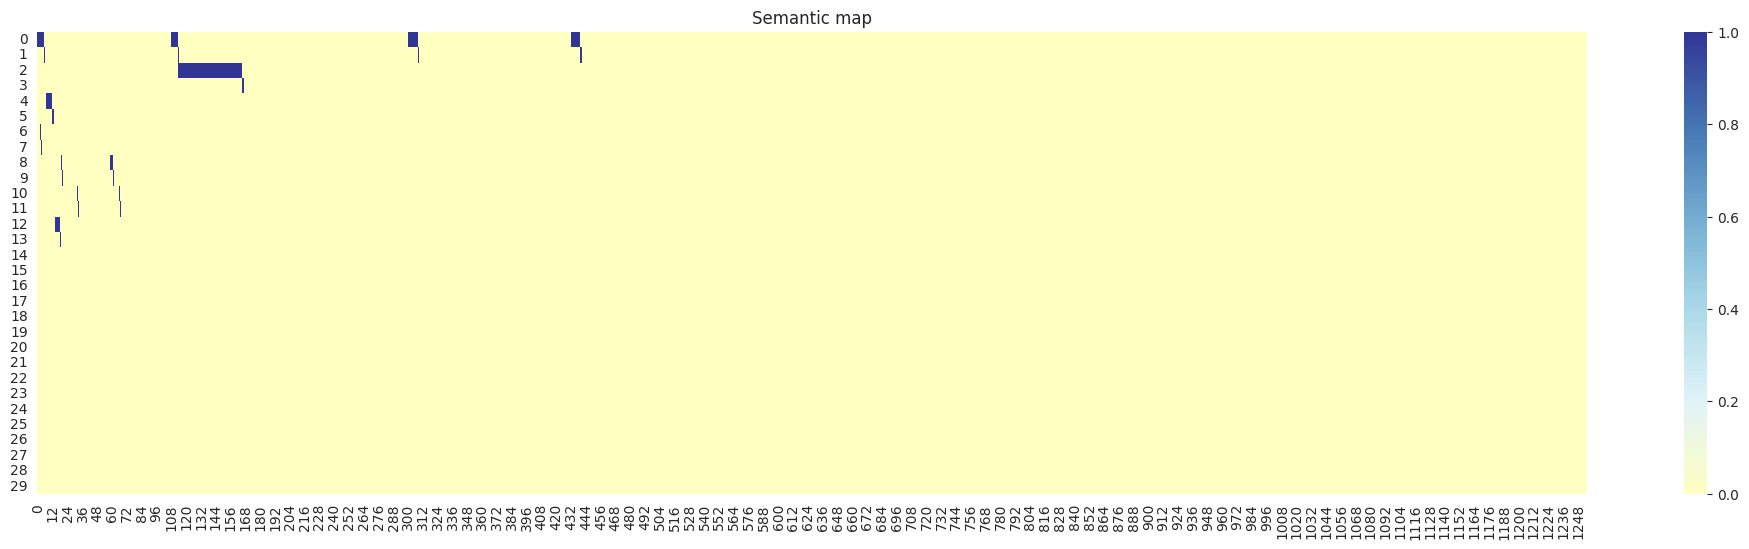

In [42]:
import numpy as np
import random
import pandas as pd

MAX_LEN = 1536
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  #   np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = MAX_LEN
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, MAX_LEN)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      #       print(dp)

      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        # row = stats_valid.loc[doc_id]
        if random.random() < 0.6:  # 60% of samples
          nonzerozz = np.where(sm[:, 1::2] > 0)[0] #take every second row, because these are end marks
#           nonzerozz = nonzerozz
          
          segment_center = random.choice(nonzerozz)
          if len(nonzerozz)==0:
             segment_center=0


          # segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center

          # if not pd.isna(row['value_span']) and random.random() < 0.7:  ##select value token as a center
          #   segment_center = int(row['value_span'])

          # _off = random.randint(max_len // 4, max_len // 2)
          _off = random.randint(-max_len//10, max_len//2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          if start_from >=len(emb):
            start_from = len(emb)-1
#           print('start_from', start_from)
#           if random_row != 1:#subject row, see semantic_map_keys
#               subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)

      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      #       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
    #     print('batch_output_subj', len(batch_output_subj))
    #     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=TEST_SIZE, stratify=stats_valid[['subject']], random_state=TRAIN_TEST_SPLIT_SEED)

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, batch_size=10, augment_samples=True)

sample = next(_gen)
# print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 1500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [43]:
mlflow.log_param('dataset_len_train', len(train_indices) )
mlflow.log_param('dataset_len_test', len(test_indices) )

278

In [44]:
SAMPLE_DOC_ID

'5ded4e284ddc27bcf92dd6ce'

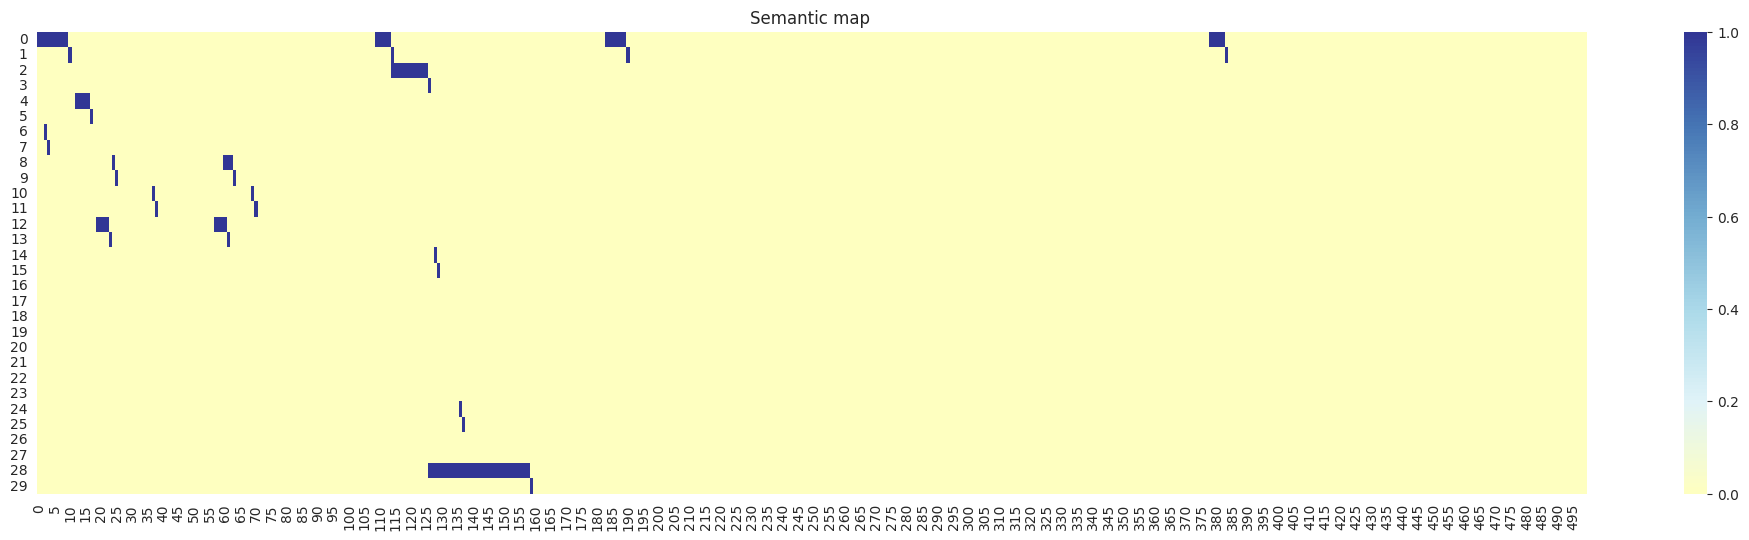

In [45]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 5ded07194ddc27bcf92dd5ed
test_indices[0]: 63ce4a4de83d1ee490f3f6f6


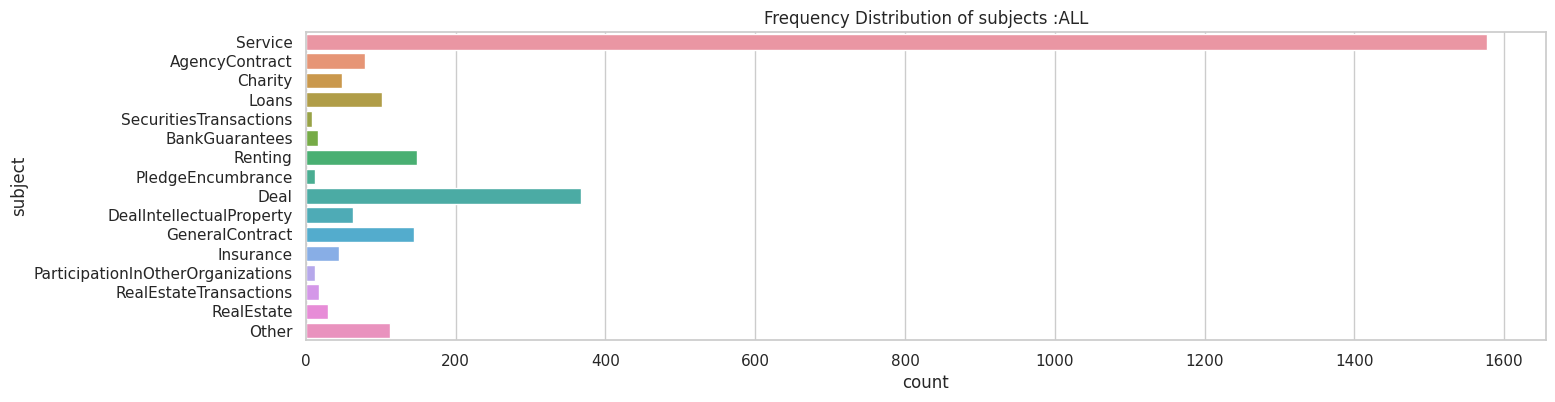

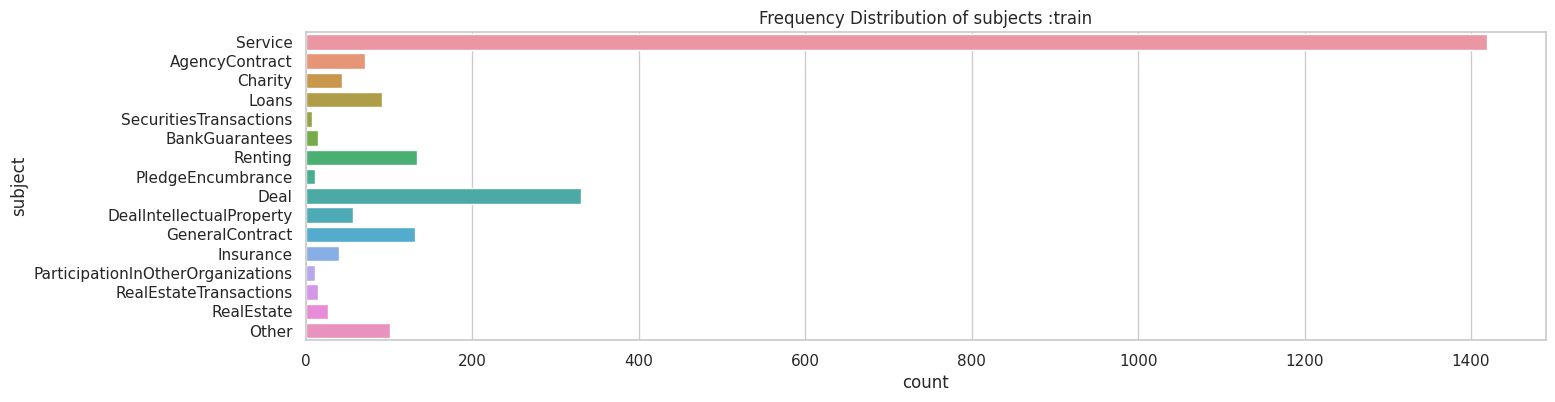

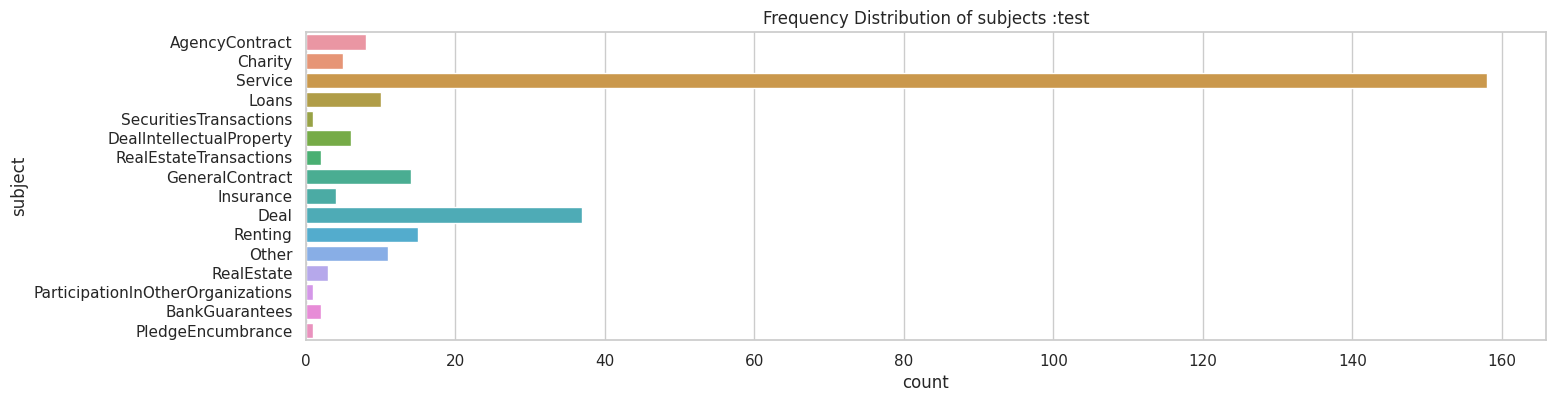

In [46]:

BATCH_SIZE = 96
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [47]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	96
train_samples:	10004
test_samples:	278
steps_per_epoch:	104
validation_steps:	52


# Models 🦖

In [48]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [49]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = EPOCHS
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [50]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [51]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = EPOCHS
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [52]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = EPOCHS
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [53]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = EPOCHS
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [54]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



if False:
    model_factory_fn = uber_detection_model_005_1_1
    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
    # umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

In [55]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = EPOCHS
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [56]:
23

23

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [57]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN and False:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = EPOCHS
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

## 🥰 Att model

In [58]:
from tf_support.tools import KerasTrainingContext
from tf_support.super_contract_model import config, make_att_model

 


model_factory_fn=make_att_model      
umodel = make_att_model() 

if TRAIN_FROM_CP:
    weights = get_weights_filename(model_factory_fn)
else:
    weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'

logger.info(f'LOADING {weights}')
print(f'LOADING {weights}')

umodel.load_weights(weights, by_name=True, skip_mismatch=True)
umodel.summary()

# raise "forsibly stopped"

2023-02-16 09:10:47.031496: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-16 09:10:47.564459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 09:10:47.565124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-16 09:10:47.565146: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-16 09:10:47.565190: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-16 09:10:47.565211: I tensorflow/stream_executor/platform/defa

True /root/artem/analyser/training_reports/make_att_model.h5
LOADING /root/artem/analyser/training_reports/make_att_model.h5
Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
rmb_plus_tokens (Concatenate)   (None, None, 1039)   0     

In [59]:
# dot_img_file = f'{umodel.name}.png'
# keras.utils.plot_model(umodel, to_file=dot_img_file, show_shapes=True)

In [60]:
def train_and_evaluate_model(self, model:Model, generator, test_generator, retrain=False, lr=None):
    print(f'model.name == {model.name}')
    self.trained_models[model.name] = model.name
    if self.EVALUATE_ONLY:
      print(f'training skipped EVALUATE_ONLY = {self.EVALUATE_ONLY}')
      return

    _log_fn = f'{model.name}.{self.session_index}.log.csv'
    _logger1 = CSVLogger(self.model_checkpoint_path / _log_fn, separator=',', append=not retrain)
    _logger2 = CSVLogger(_log_fn, separator=',', append=not retrain)

    checkpoint_weights = ModelCheckpoint(self.model_checkpoint_path / (model.name + ".h5"),
                                         monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True,
                                         verbose=1)

    lr_logged = None
    if not retrain:
      lr_logged, epoch = self.get_lr_epoch_from_log(model.name)
    else:
      epoch = 0

    if lr_logged is not None:
      K.set_value(model.optimizer.lr, lr_logged)

    if lr is not None:
      K.set_value(model.optimizer.lr, lr)

    print(f'continue: lr:{K.get_value(model.optimizer.lr)}, epoch:{epoch}')


    history = model.fit(
                    generator, batch_size=BATCH_SIZE,
#                     steps_per_epoch=train_steps,
                    epochs=self.EPOCHS,
                    validation_data=test_generator,
                    validation_steps=self.validation_steps,
                    steps_per_epoch=self.steps_per_epoch,
#                     class_weight=class_weights,
                    initial_epoch=epoch,
                    max_queue_size=15,
#                     workers=8,
                    callbacks=[self.reduce_lr, checkpoint_weights, _logger2, _logger1]
                    )
    
    
#     history = model.fit_generator(
#       generator=generator,
#       epochs=self.EPOCHS,
#       callbacks=,  # , _logger1, _logger2
#       steps_per_epoch=self.steps_per_epoch,
#       validation_data=,
#       validation_steps=,
#       initial_epoch=, use_multiprocessing=True, )

    self.HISTORIES[model.name] = history
    self.save_stats(model.name)

    return history


if TRAIN:
  config.LR =0.0005
  ctx.unfreezeModel(umodel)
#   umodel.summary()
  
  ctx.EPOCHS = EPOCHS
  ctx.EVALUATE_ONLY = False
 
  BATCH_SIZE = 128
  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  train_and_evaluate_model(ctx, umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)
else:
    logger.warning(f'skip training, because TRAIN={TRAIN}')
    
    
threshold = umodel.get_layer('O1_tagging').get_weights()
print('threshold=', threshold[0][0])

mlflow.log_metric('trained_tags_threshold', threshold[0][0])

model.name == make_att_model
continue: lr:0.0005000000237487257, epoch:0


2023-02-16 09:10:49.377573: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-02-16 09:10:49.377597: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-02-16 09:10:49.377621: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2023-02-16 09:10:49.399836: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so.11.2
2023-02-16 09:10:49.497618: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-02-16 09:10:49.498833: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2023-02-16 09:10:49.781712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-16 09:10:49.782532: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2023-02-16 09:

  1/104 [..............................] - ETA: 7:28 - loss: 0.0110 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0081 - O1_tagging_mse: 9.9224e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0073

2023-02-16 09:10:54.243523: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-02-16 09:10:54.243550: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/104 [..............................] - ETA: 48s - loss: 0.0137 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0080     

2023-02-16 09:10:54.622337: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-16 09:10:54.623812: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2023-02-16 09:10:54.651234: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 7679 callback api events and 7671 activity events. 
2023-02-16 09:10:54.709935: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-02-16 09:10:54.783352: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp5621dz7a/train/plugins/profile/2023_02_16_09_10_54
2023-02-16 09:10:54.827741: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmp5621dz7a/train/plugins/profile/2023_02_16_09_10_54/tensor.trace.json.gz
2023-02-16 09:10:54.901853: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directo

 16/104 [===>..........................] - ETA: 2:31 - loss: 0.0143 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0088 - O1_tagging_mse: 8.1196e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

2023-02-16 09:11:21.491743: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 804782080 exceeds 10% of free system memory.


101/104 [============================>.] - ETA: 5s - loss: 0.0149 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0094 - O1_tagging_mse: 8.7379e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

2023-02-16 09:14:08.388312: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 803733504 exceeds 10% of free system memory.


104/104 [==============================] - ETA: 0s - loss: 0.0148 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0093 - O1_tagging_mse: 8.7734e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

2023-02-16 09:14:16.496828: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 805306368 exceeds 10% of free system memory.
2023-02-16 09:14:19.520681: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 805306368 exceeds 10% of free system memory.
2023-02-16 09:14:23.147348: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 805306368 exceeds 10% of free system memory.


104/104 [==============================] - 345s 3s/step - loss: 0.0148 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0093 - O1_tagging_mse: 8.7734e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084 - val_loss: 0.0096 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0046 - val_O1_tagging_mse: 8.6613e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0041


2023/02/16 09:16:35 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'generator'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/02/16 09:16:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Epoch 00001: val_loss improved from inf to 0.00963, saving model to /root/artem/analyser/training_reports/make_att_model.h5


2023-02-16 09:16:40.827516: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpr2irsoev/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpr2irsoev/model/data/model/assets
2023/02/16 09:16:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/root/artem/env/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


threshold= 0.042054676


# Evaluate last checkpoint

In [61]:

if umodel:
    del umodel
    
#######################################
#######################################
model_fn = make_att_model
# model_fn = uber_detection_model_003
#######################################
#######################################
 

weights = ctx.model_checkpoint_path /  f'{model_factory_fn.__name__}.h5'
logger.info(f'LOADING {weights}')
print(f'LOADING {weights}')

umodel = make_att_model() 
umodel.load_weights(weights, by_name=False, skip_mismatch=False)
umodel.trainable = False
umodel.summary()

# umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')



#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

INFO - 2023-02-16 09:16:55,047 - retrain_ipynb - LOADING /root/artem/analyser/training_reports/make_att_model.h5
INFO:retrain_ipynb:LOADING /root/artem/analyser/training_reports/make_att_model.h5


LOADING /root/artem/analyser/training_reports/make_att_model.h5
Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
rmb_plus_tokens (Concatenate)   (None, None, 1039)   0           input_text_emb[0][0]             
                     

### training history

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


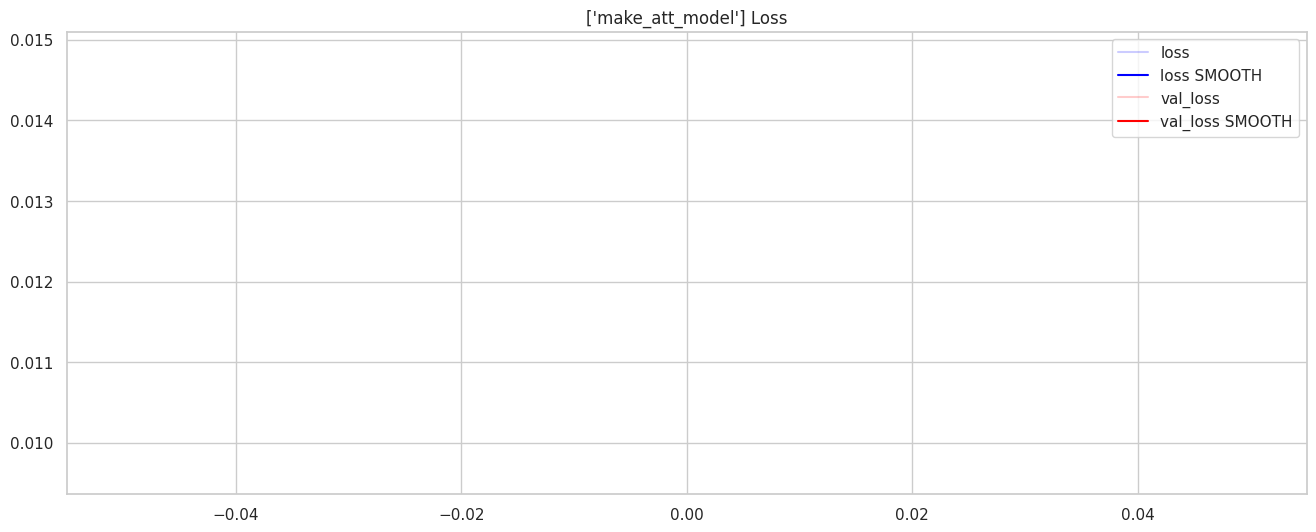

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


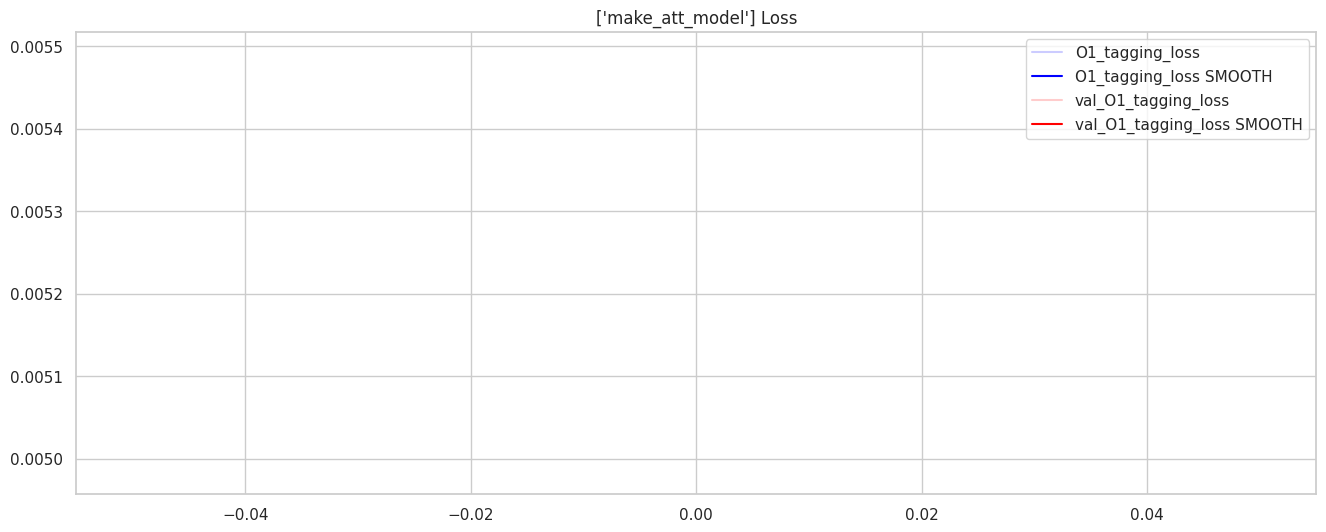

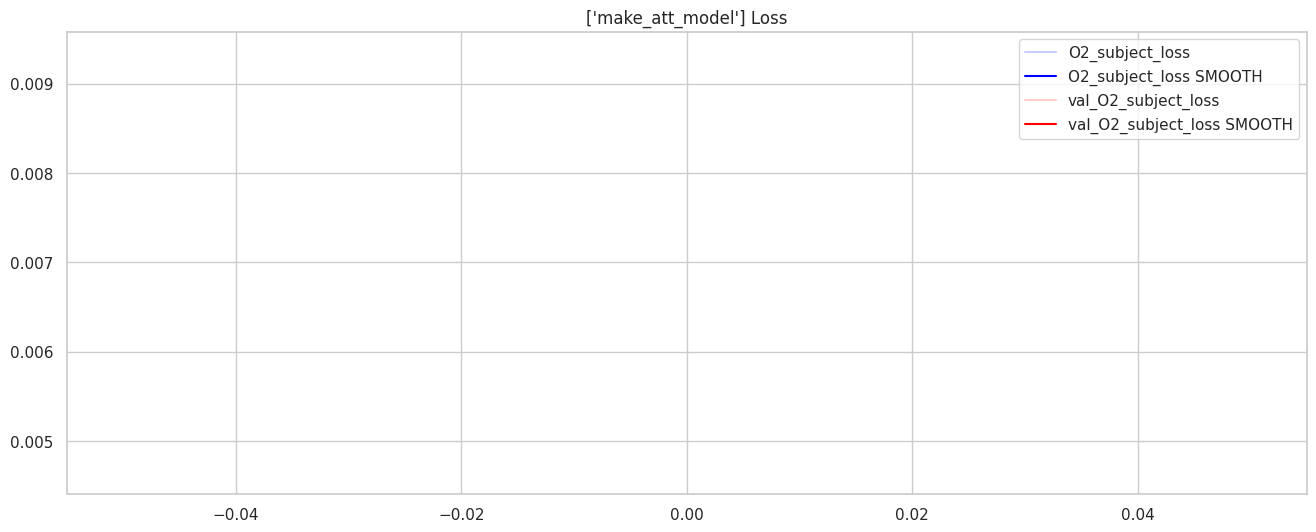

In [62]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')


In [63]:
from tf_support.super_contract_model import make_xyw
logger.error("fix prediction!!")
if False:
    sample_index = umtm.stats [umtm.stats['value']>0].index[2]
    logger.info(f'making prediction for sample doc {sample_index}')

    x, y, _ = make_xyw(sample_index, umtm.stats)
    print(f'shape of x[0]={x[0].shape}')
    print(f'shape of x[1]={x[1].shape}')

    t1 = np.expand_dims(x[0], axis=0)
    t2 = np.expand_dims(x[1], axis=0)

    print(f'shape of t1={t1.shape}')
    print(f'shape of t2={t2.shape}')
    print(f'umodel.name ={umodel.name}')

    prediction = umodel.predict(x=[t1, t2], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
    # .T
    plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

ERROR - 2023-02-16 09:16:56,307 - retrain_ipynb - fix prediction!!
ERROR:retrain_ipynb:fix prediction!!


# Evaluate recent model (with external notebook)

DEBUG:eva;_ipynb:--=logging started=--
/tmp/ipykernel_3928697/228146364.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
INFO:retrain_contract_uber_model:loading trainset meta from /root/artem/work/contract_trainset_meta.csv
INFO:retrain_contract_uber_model:number of samples BEFORE clean-up: 2782
INFO:retrain_contract_uber_model:number of samples AFTER clean-up: 2782
INFO:retrain_contract_uber_model:OK
INFO:retrain_contract_uber_model:TOTAL DATAPOINTS IN TRAINSET: 2782
INFO:retrain_contract_uber_model:loading trainset meta from /root/artem/work/contract_trainset_meta.csv
INFO:retrain_contract_uber_model:number of samples BEFORE clean-up: 2782
INFO:retrain_contract_uber_model:number of samples AFTER clean-up: 2782


Running in colab: False


INFO:retrain_contract_uber_model:OK
INFO:retrain_contract_uber_model:TOTAL DATAPOINTS IN TRAINSET: 2782
ERROR - 2023-02-16 09:17:09,389 - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fc6452a1d0a1603c7a0c9eb-datapoint-embeddings.npy'
ERROR:eva;_ipynb:[Errno 2] No such file or directory: '/root/artem/work/datasets/5fc6452a1d0a1603c7a0c9eb-datapoint-embeddings.npy'
ERROR - 2023-02-16 09:17:23,586 - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb3d4a078df3635f5441c63-datapoint-embeddings.npy'
ERROR:eva;_ipynb:[Errno 2] No such file or directory: '/root/artem/work/datasets/5fb3d4a078df3635f5441c63-datapoint-embeddings.npy'
ERROR - 2023-02-16 09:17:37,139 - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbad2ca2b4551c06107864-datapoint-embeddings.npy'
ERROR:eva;_ipynb:[Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbad2ca2b4551c06107864-datapoint-embeddings.npy'
ERROR - 2023-0

total docs in /root/artem/work/documents.json is 622


ERROR - 2023-02-16 09:17:55,266 - eva;_ipynb - No key in stats: '5ded06f04ddc27bcf92dd4b0'
ERROR:eva;_ipynb:No key in stats: '5ded06f04ddc27bcf92dd4b0'
ERROR - 2023-02-16 09:17:55,279 - eva;_ipynb - No key in stats: '5ded07034ddc27bcf92dd4d7'
ERROR:eva;_ipynb:No key in stats: '5ded07034ddc27bcf92dd4d7'
ERROR - 2023-02-16 09:17:55,307 - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd4eb'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd4eb'
ERROR - 2023-02-16 09:17:55,319 - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd4ed'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd4ed'
ERROR - 2023-02-16 09:17:55,334 - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd4fc'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd4fc'
ERROR - 2023-02-16 09:17:55,363 - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd52a'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd52a'
ERROR - 2023-02-16 09:17:55,395 - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd53

errors count: 83
total docs in /root/artem/work/documents.json is 539
Договор №САХ-16/09000/00037/Д.
г. Санкт-Петербург                                              "16" мая 2016 год.
Общество с ограниченной ответственностью «Газпромнефть-Сахалин», именуемое в дальнейшем «Продавец», в лице генеральн
SAMPLE_DOC_ID 5ded004f4ddc27bcf92dd490
semantic map shape is: (3366, 30)


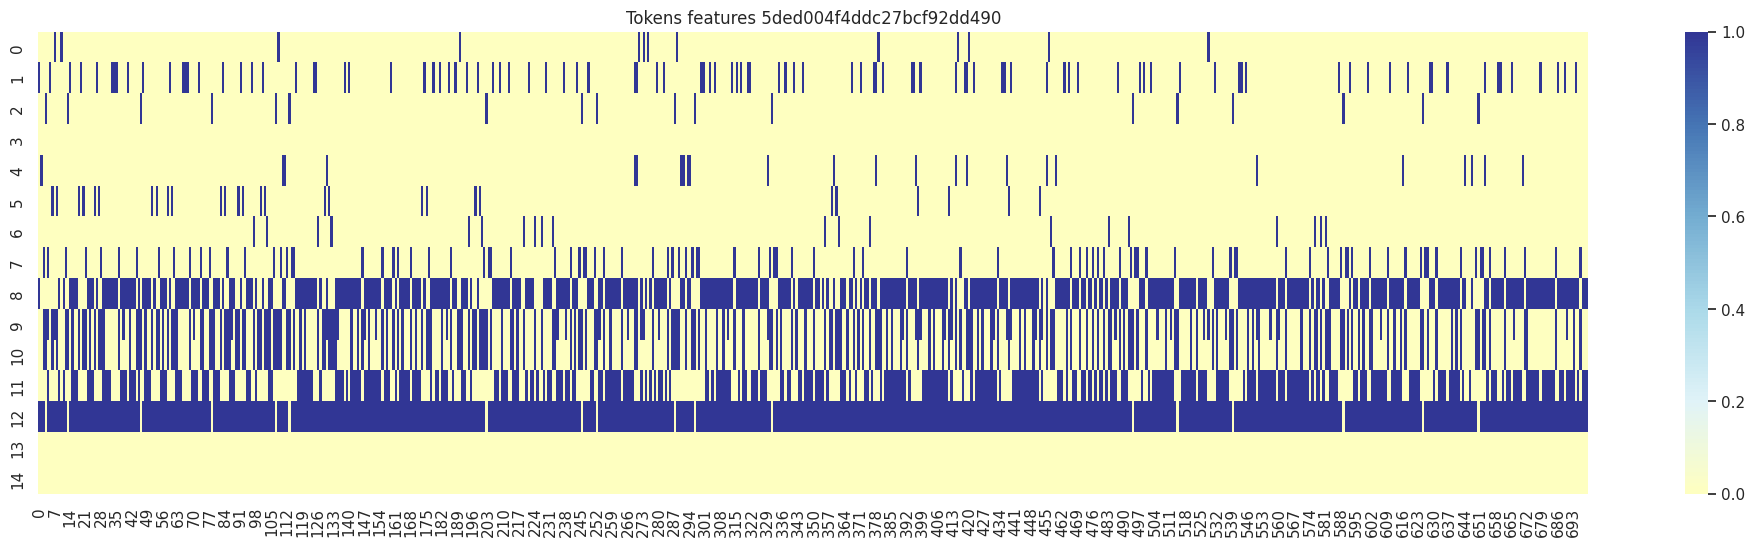

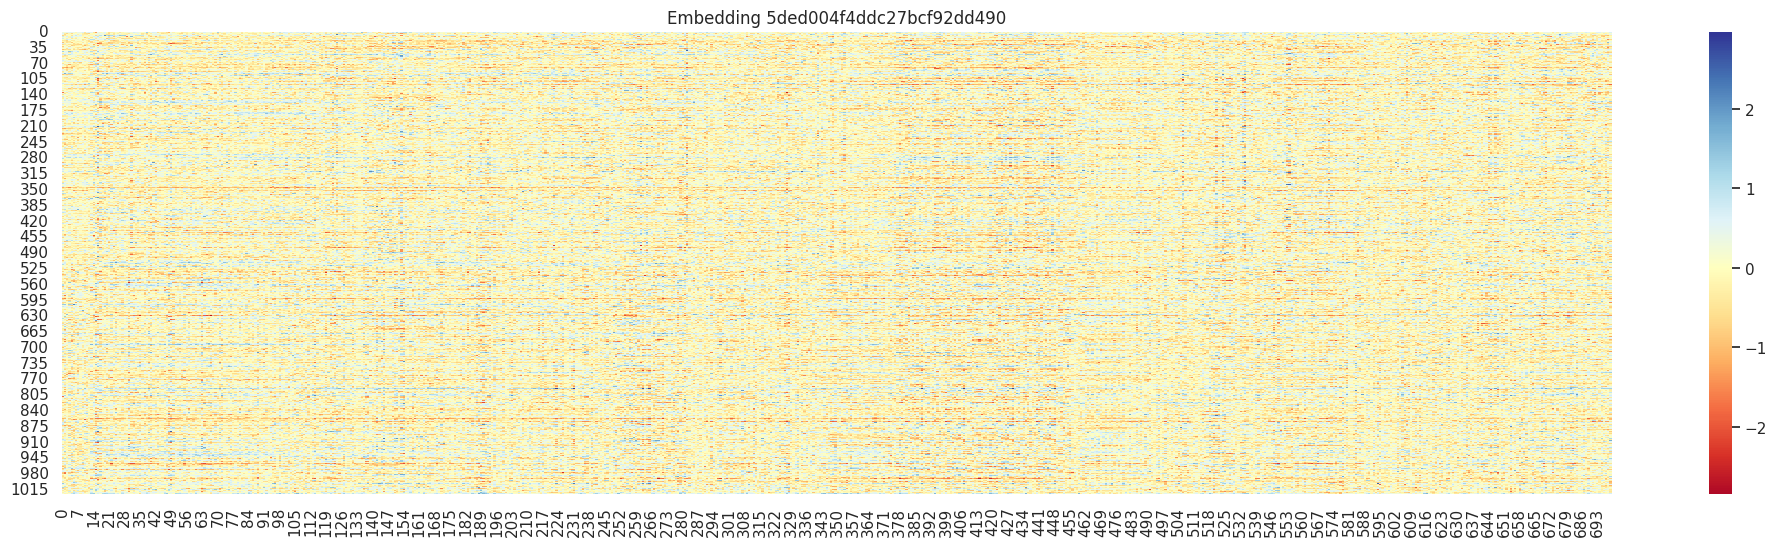

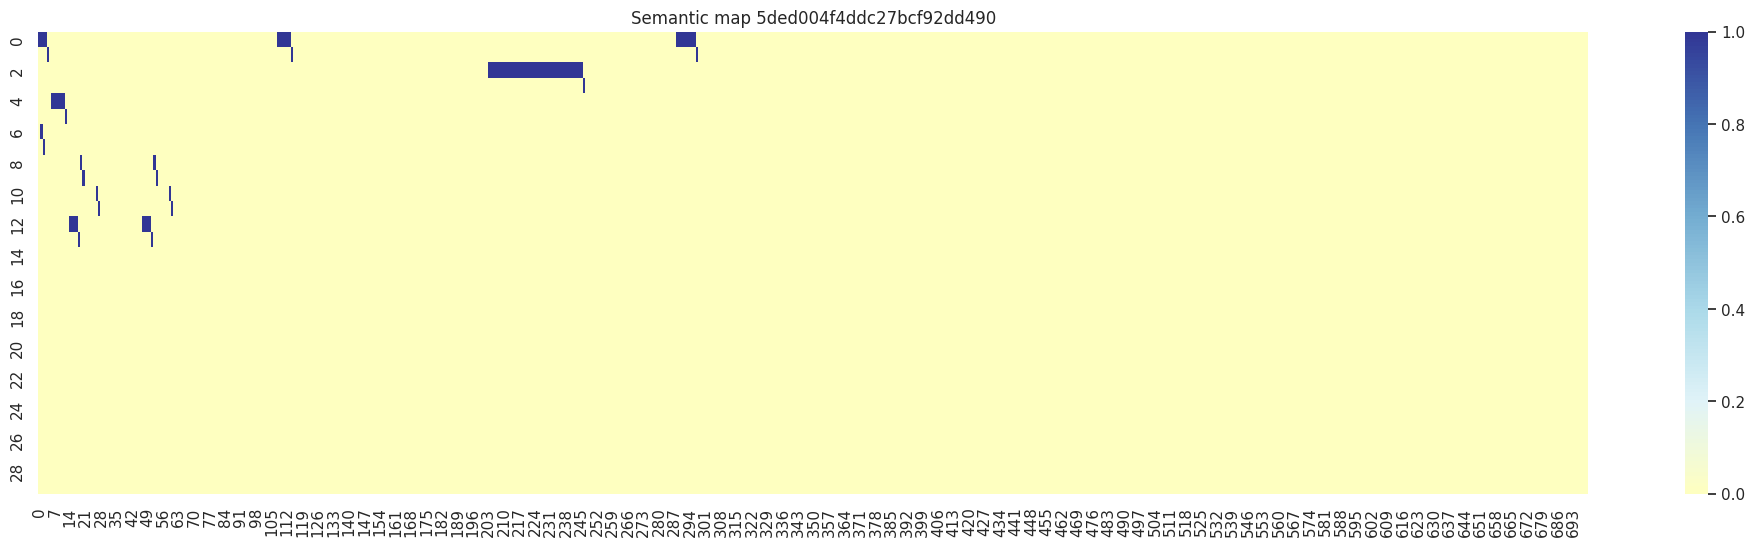

[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/work
INFO:gpn:model_checkpoint_path: /root/artem/work


********************************************************************************
model_factory_fn defined as make_att_model
********************************************************************************
umodel defined as make_att_model
Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
_____________________________________________

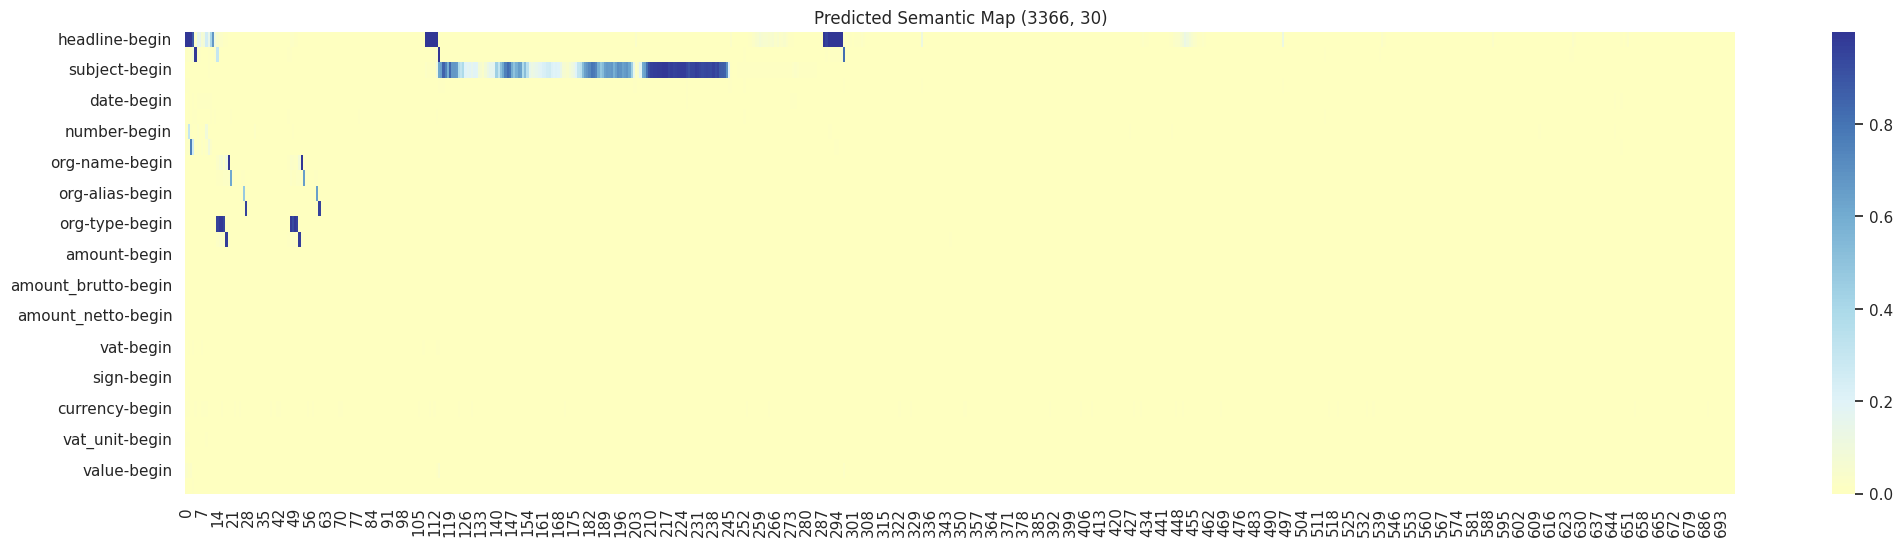

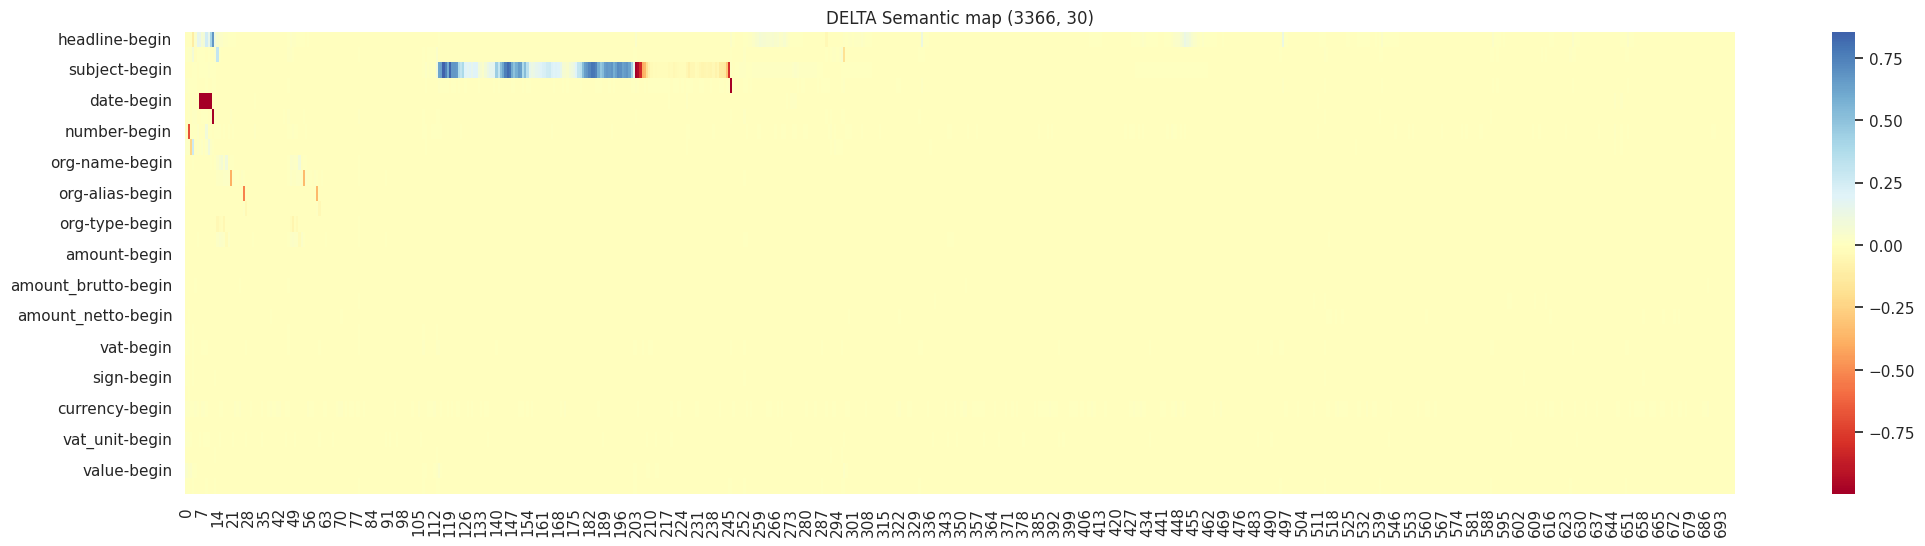

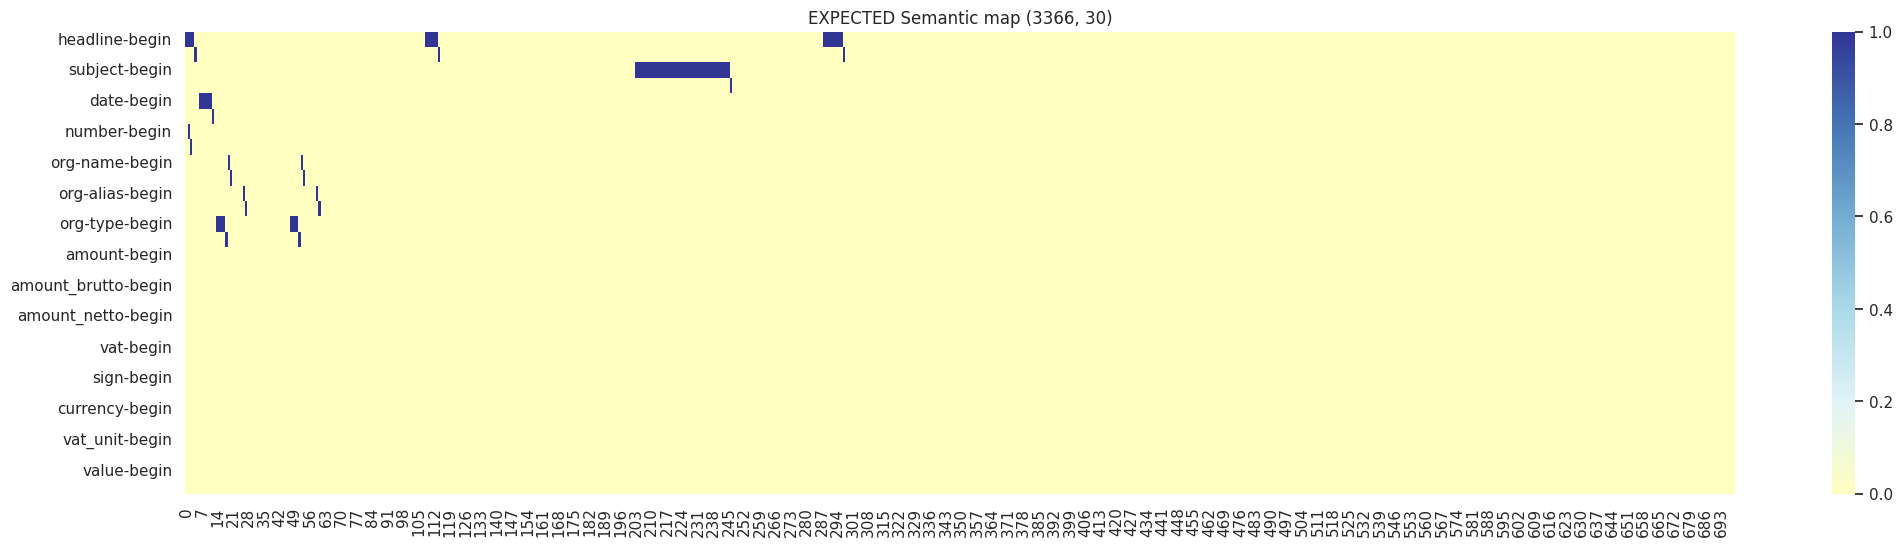

SemanticTag: number [1, 2] САХ-16/09000/00037/Д 0.30857306718826294
None
(1206, 1216)
None
SemanticTag: currency (1215, 1216) RUB 0.9039072394371033
SemanticTag: sign (1206, 1209) -1 0.28997984528541565
SemanticTag: amount (1209, 1210) 350000.0 1.0
None
None
None


brutto None
netto SemanticTag: amount (1209, 1210) 350000.0 1.0
amount None
vat None
SemanticTag: subject (208, 244) Лом и произвести оплату Лома, в соответствии с ГОСТами 2787-75 (для Лома черных металлов) и/или 1639-2009 (для Лома цветных металлов), на условиях настоящего Договора по ценам, указанным в Спецификации 0.9462461471557617
actual_batch_size 96


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

DB HOST IS: 192.168.10.36


[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object


actual_batch_size 96


[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object


actual_batch_size 96
actual_batch_size 96


[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:

actual_batch_size 96


[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object


actual_batch_size 96


[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object


actual_batch_size 96


[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object


actual_batch_size 96
actual_batch_size 64


[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
[contract_parser.py:412 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
ERROR:gpn:cannot unpack non-iterable NoneType object
/root/artem/env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/root/artem/env/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

['AgencyContract', 'BankGuarantees', 'Charity', 'Deal', 'DealIntellectualProperty', 'GeneralContract', 'Insurance', 'Loans', 'ParticipationInOtherOrganizations', 'PledgeEncumbrance', 'RealEstate', 'RealEstateTransactions', 'Renting', 'SecuritiesTransactions', 'Service']


/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


make_att_model
                                   precision    recall  f1-score   support

                   AgencyContract      0.947     1.000     0.973        36
                   BankGuarantees      0.727     0.889     0.800         9
                          Charity      0.857     0.947     0.900        19
                             Deal      0.963     0.913     0.938       115
         DealIntellectualProperty      0.800     1.000     0.889        36
                  GeneralContract      0.982     0.831     0.900        65
                        Insurance      1.000     1.000     1.000        22
                            Loans      0.985     0.943     0.964        70
                            Other      0.000     0.000     0.000         0
ParticipationInOtherOrganizations      1.000     0.800     0.889        10
                PledgeEncumbrance      1.000     1.000     1.000         4
                       RealEstate      0.909     1.000     0.952        10
         

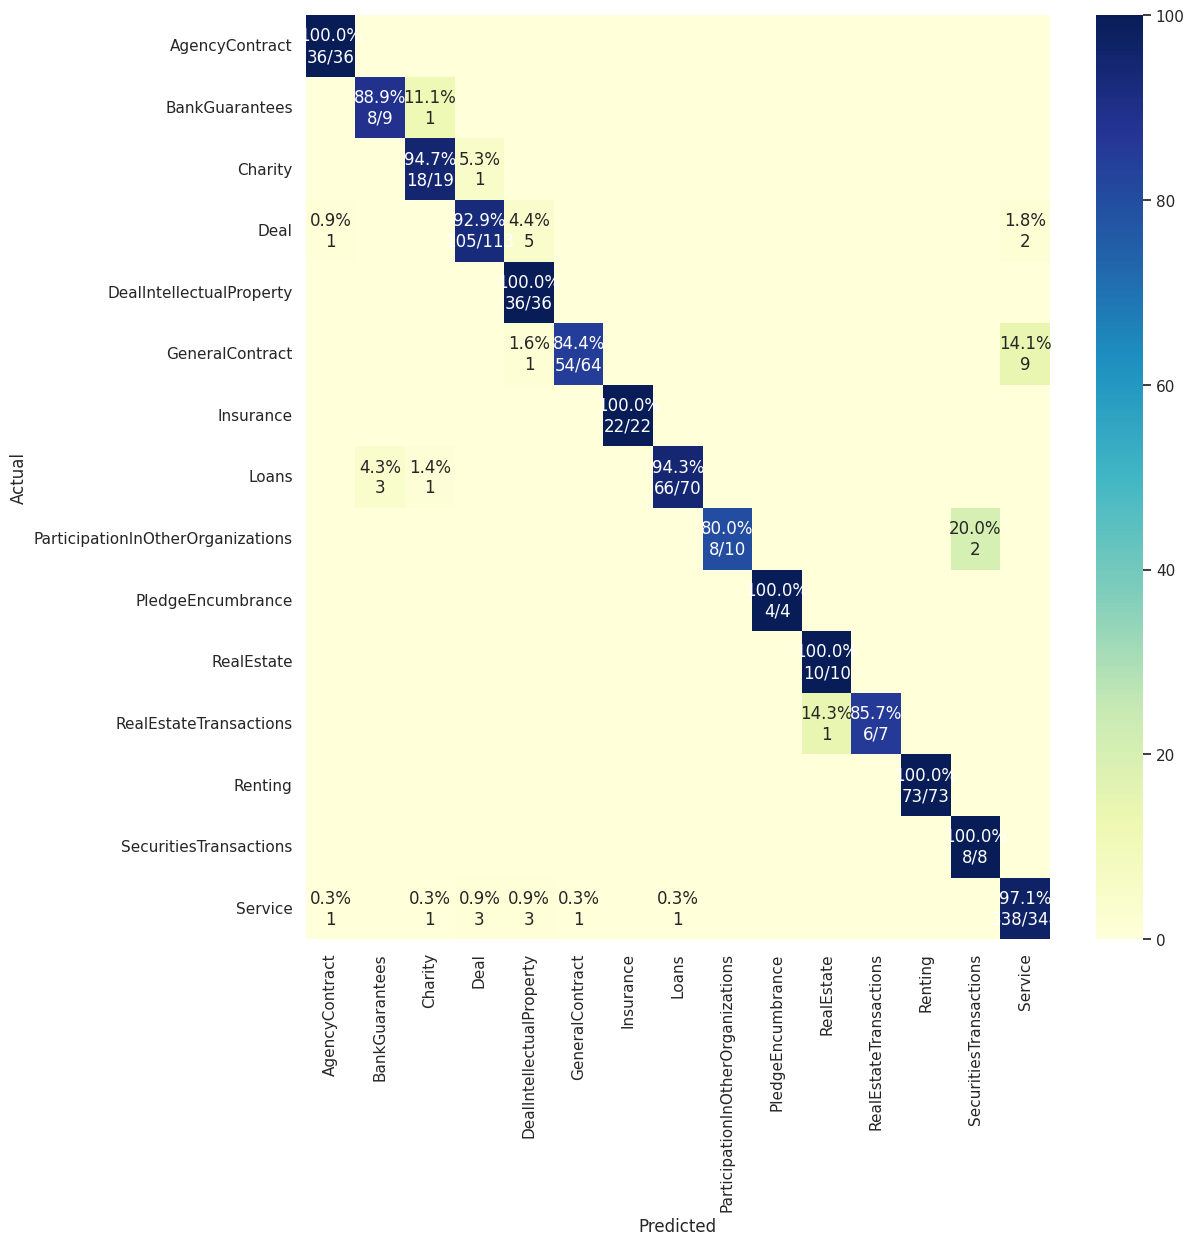

In [64]:
%run -i -t /root/artem/analyser/trainsets/eval_contract_uber_model.ipynb
 